# Initial Analysis of BIXI Data

In [26]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import os
import json
import folium
from folium import plugins
from folium.plugins import HeatMap
import re
from haversine import haversine, Unit
from datetime import datetime, date, time
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
from requests import get
from bs4 import BeautifulSoup
from collections import namedtuple

In [27]:
DATA_PATH = './BixiMontrealRentals/'

In [28]:
#load bike ride data
def load_data():
    #loads data from all years and months into single dataframe
    df = pd.DataFrame()
    for year in range(4,10):
        for month in range(4,12):
            if month>9:
                file_loc = '%sOD_201%d-%d.csv'%(DATA_PATH,year,month)
                if year==9:
                    return df #only have data up to Sep 2019
            else:
                file_loc = '%sOD_201%d-0%d.csv'%(DATA_PATH,year,month)
            month_data = pd.read_csv(file_loc, sep=',')
            df = df.append(month_data, ignore_index=True)

raw_data = load_data()
raw_data.head()

C:\anaconda\envs\ada\lib\site-packages\IPython\core\interactiveshell.py:3249: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


,start_date,start_station_code,end_date,end_station_code,duration_sec,is_member
0,2014-04-15 00:01,6209,2014-04-15 00:18,6436,1061,1
1,2014-04-15 00:01,6214,2014-04-15 00:11,6248,615,1
2,2014-04-15 00:01,6164,2014-04-15 00:18,6216,1031,1
3,2014-04-15 00:01,6214,2014-04-15 00:24,6082,1382,1
4,2014-04-15 00:02,6149,2014-04-15 00:08,6265,347,1


In [29]:
#load station data - need to look at all year's station data in case some stations were added or removed throughout the years
stations = pd.read_csv('%sStations_2019.csv'%(DATA_PATH), sep=',')

#the station locations are not the same for the same station code each year
#since we are mainly analysing the 2019 data we want to use the 2019 station locations
#analysis we are doing for the other years is not related to the station locations so it's ok not to have the station location data

for year in range(8,3,-1):
    station_year = pd.read_csv('%sStations_201%d.csv'%(DATA_PATH,year), sep=',')
    new_stations = station_year[~station_year['code'].isin(stations.code)]
    stations = stations.append(new_stations, ignore_index=True) #add only stations which aren't already in list

stations = stations.set_index('code')
stations.head()

,name,latitude,longitude
code,,,
10002,Métro Charlevoix (Centre / Charlevoix),45.478228,-73.569651
4000,Jeanne-d'Arc / Ontario,45.549598,-73.541874
4001,Graham / Brookfield,45.520075,-73.629776
4002,Graham / Wicksteed,45.516937,-73.640483
5002,St-Charles / Montarville,45.533682,-73.515261


In [30]:
raw_data.start_date = pd.to_datetime(raw_data.start_date)
raw_data.end_date = pd.to_datetime(raw_data.end_date)
raw_data.dtypes

start_date            datetime64[ns]
start_station_code            object
end_date              datetime64[ns]
end_station_code              object
duration_sec                   int64
is_member                      int64
dtype: object

In [31]:
#merge the bike data and station tables into one
data = raw_data.merge(stations[['latitude','longitude']], how='left', left_on=['start_station_code'], right_index=True)
data = data.merge(stations[['latitude','longitude']], how='left', left_on=['end_station_code'], right_index=True, suffixes=('_start','_end'))


In [32]:
#create new columns for the day, hour, and year
def split_date(col,df):
    df['%s_day'%(col)] = df['%s_date'%(col)].apply(lambda x: x.day)
    df['%s_hour'%(col)] = df['%s_date'%(col)].apply(lambda x: x.hour)
    return df

data['year'] = data['start_date'].apply(lambda x: x.year)
data['month'] = data['start_date'].apply(lambda x: x.month)

data = split_date('start', data)
data = split_date('end', data)

data.head()

,start_date,start_station_code,end_date,end_station_code,duration_sec,is_member,latitude_start,longitude_start,latitude_end,longitude_end,year,month,start_day,start_hour,end_day,end_hour
0,2014-04-15 00:01:00,6209,2014-04-15 00:18:00,6436,1061,1,45.512541,-73.570677,45.485801,-73.595797,2014,4,15,0,15,0
1,2014-04-15 00:01:00,6214,2014-04-15 00:11:00,6248,615,1,45.516091,-73.570129,45.518593,-73.581566,2014,4,15,0,15,0
2,2014-04-15 00:01:00,6164,2014-04-15 00:18:00,6216,1031,1,45.533314,-73.583737,45.514840,-73.584779,2014,4,15,0,15,0
3,2014-04-15 00:01:00,6214,2014-04-15 00:24:00,6082,1382,1,45.516091,-73.570129,45.549900,-73.583084,2014,4,15,0,15,0
4,2014-04-15 00:02:00,6149,2014-04-15 00:08:00,6265,347,1,45.538670,-73.569360,45.539259,-73.577459,2014,4,15,0,15,0


In [33]:
#average proximity of station rides
#since the only accurate stations are those of 2019, we will only calculate the distance for 2019 data
#since it's computationally intensive 
data19 = data.query('year==2019')

#haversine function calculates the distance between two coordinates (lat, lon) - can install through 'pip install haversine'
#outputs distance in km
data19['distance'] = data19.apply(lambda x: haversine((x.latitude_start,x.longitude_start),(x.latitude_end,x.longitude_end)),axis=1)

C:\anaconda\envs\ada\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [34]:
#save the combined set to pickle
data.to_pickle("../combined_new_stations")

In [35]:
stations.to_pickle("../stations")

In [36]:
#get indices of broken bikes
#broken bikes are considered to be those that are returned to the same stations within 5 minutes (300s)
broken_bikes = data19[(data19['distance']==0.0) & (data19['duration_sec']<180)]

#drop these rows from the DF
data19.drop(labels=broken_bikes.index, inplace=True)
data19.reset_index()
data19.head()

C:\anaconda\envs\ada\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,start_date,start_station_code,end_date,end_station_code,duration_sec,is_member,latitude_start,longitude_start,latitude_end,longitude_end,year,month,start_day,start_hour,end_day,end_hour,distance
20598137,2019-04-14 07:55:22,6001,2019-04-14 08:07:16,6132,713,1,45.510351,-73.556508,45.529135,-73.559234,2019,4,14,7,14,8,2.099436
20598138,2019-04-14 07:59:31,6411,2019-04-14 08:09:18,6411,587,1,45.513303,-73.572961,45.513303,-73.572961,2019,4,14,7,14,8,0.000000
20598139,2019-04-14 07:59:55,6097,2019-04-14 08:12:11,6036,736,1,45.492897,-73.580294,45.504242,-73.553469,2019,4,14,7,14,8,2.441823
20598140,2019-04-14 07:59:57,6310,2019-04-14 08:27:58,6345,1680,1,45.505403,-73.621166,45.554961,-73.610737,2019,4,14,7,14,8,5.570159
20598141,2019-04-14 08:00:37,7029,2019-04-14 08:14:12,6250,814,0,45.538021,-73.583524,45.536785,-73.614888,2019,4,14,8,14,8,2.446698


In [37]:
#save the 2019 complete data
data19.to_pickle("../combined2019")

# Load saved combined dataframe on restart

Run first cell to import libraries and then only this cell onwards to save time. 

In [10]:
#start from here on restart of notebook - loads the combined dataset
data = pd.read_pickle("../combined_data")

In [ ]:
data19 = pd.read_pickle("../combined2019")

In [11]:
stations = pd.read_pickle("../stations")

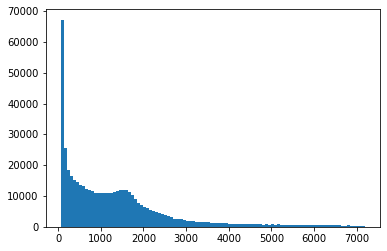

In [18]:
#distribution of return trips (comes back to same station)
return_trip = data_og[data_og['distance']==0.0]
plt.hist(return_trip['duration_sec'], bins=100)
plt.show()

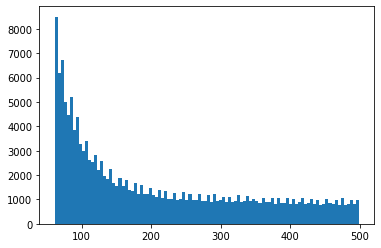

In [19]:
#looks like there is a dispraportionately large number of trips of very low duration
#closer look at the lower range
return_trip = return_trip.query('duration_sec<500')
plt.hist(return_trip['duration_sec'], bins=100)
plt.show()

# Time evolution of BIXI use

In [65]:
#station use count
station_use = data.groupby(['year','start_station_code']).size().reset_index(name='counts')
use_dur = data[['year','start_station_code','duration_sec']].groupby(['year','start_station_code']).mean().reset_index()
station_use['duration'] = use_dur['duration_sec']

station_use.head()

,year,start_station_code,counts,duration
0,2014,5002,252,1171.595238
1,2014,5003,201,1344.323383
2,2014,5004,186,1122.672043
3,2014,5005,473,865.792812
4,2014,5006,323,1051.919505


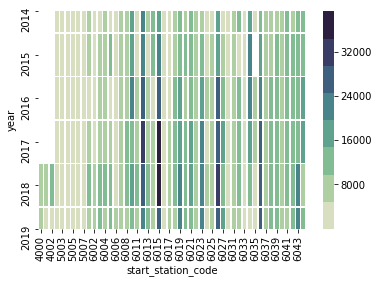

In [5]:
plot = station_use.pivot('year', 'start_station_code', 'counts')
sns.heatmap(plot.iloc[:,0:50], linewidth=0.5, cmap=sns.cubehelix_palette(8, start=.5, rot=-.75))
plt.show()

***Not an efficient way to plot since can only fit a few stations in one heatmap***

Instead: look at most popular stations regardless of year, then analyse time dependence once filter for the stations with the highest use

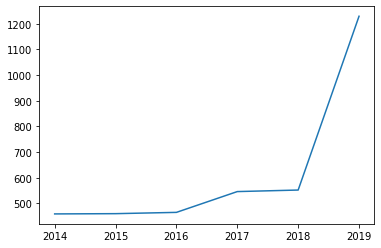

In [6]:
#number of stations
station_count = station_use.groupby('year').size().reset_index(name='num_stat')
plt.plot(station_count.year, station_count.num_stat)

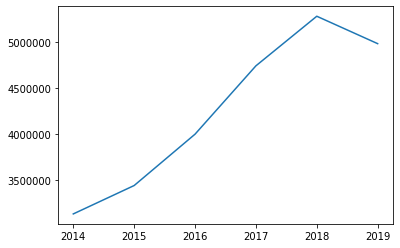

In [7]:
#total number of trips
trips = station_use.groupby('year').sum()
plt.plot(trips.index, trips.counts)

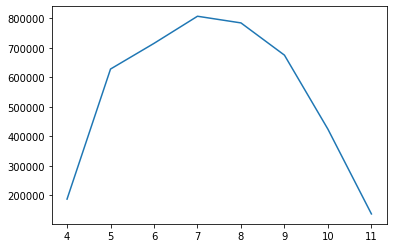

In [8]:
#use by month (averaged over the years)
monthly = data.groupby(['month','year']).size().reset_index(name='trips_per_month')
monthly = monthly[['month','trips_per_month']].groupby('month').mean()
plt.plot(monthly.index, monthly.trips_per_month)

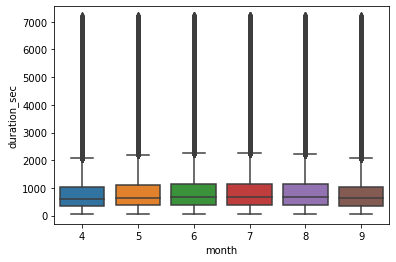

In [10]:
#ride duration by month - 2019
sns.boxplot(x='month', y='duration_sec', data=data19)

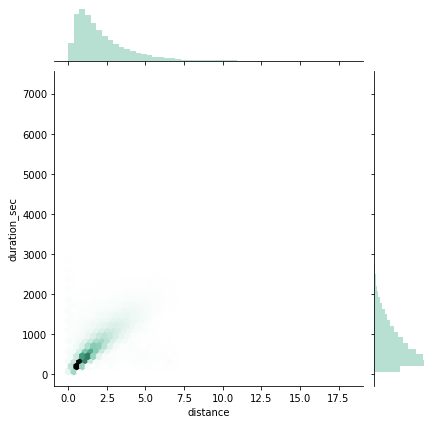

In [11]:
#distance vs duration for 2019 (all months)
sns.jointplot(data19.distance, data19.duration_sec, kind='hex', color="#4CB391")
plt.show()

We can see that most of the trips are short distance and short duration, indicating use for commuting. 

# BIXI use in 2019

In [67]:
#distribution of station popularity by start of trips from given station
station_use19 = station_use.query('year==2019')
del station_use19['year']
station_use19.drop(station_use19.tail(1).index,inplace=True) #get rid of last row which is not a listed station
station_use19['start_station_code'] = station_use19['start_station_code'].astype('int')

station_use19 = station_use19.merge(stations[['latitude','longitude']], how='left', left_on=['start_station_code'], right_on=['code'])
#sns.boxplot(x=station_use19['counts'])
station_use19

C:\anaconda\envs\ada\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\anaconda\envs\ada\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,start_station_code,counts,duration,latitude,longitude
0,4000,8127,893.446290,45.549457,-73.541649
1,4001,1369,1027.604091,45.502629,-73.527750
2,4002,3447,1094.459530,45.506194,-73.569968
3,5002,631,1207.028526,45.533200,-73.515600
4,5003,458,1147.633188,45.529400,-73.517800
...,...,...,...,...,...
1223,7145,56,601.625000,45.453319,-73.576775
1224,7146,89,600.505618,45.492222,-73.569348
1225,7147,113,802.238938,45.534739,-73.620769
1226,7148,28,992.928571,45.559884,-73.633568


From this can see that most stations are used less than 15,000 times per year. Now want to list the most frequently used stations (with latitude and longitude so can compare to public transpo) and plot them on a map. 

In [68]:
#create a dataframe with full information on trips from the most popular stations
station_use19_pop = station_use19.query('counts>20000')
popular = data19[data19['start_station_code'].isin(station_use19_pop['start_station_code'])]
popular = popular[['start_station_code','end_station_code','latitude_start','longitude_start','latitude_end','longitude_end','distance']]
pop_stations = popular.groupby('start_station_code')

In [29]:
#visualize stations on map
montreal = [45.5017, -73.5673]

m = folium.Map(location=montreal, tiles='Stamen Terrain', zoom_start=13)
for lat, lng, name, count in zip(station_use19_pop.latitude, station_use19_pop.longitude, station_use19_pop.start_station_code, station_use19_pop.counts):
    m.add_child(folium.CircleMarker(location=[lat,lng], fill='true', radius=count/10000, popup=name, fill_color='red', color='red')) #CircleMarker gives dot, Marker gives drop    
m

In [15]:
#station popularity as a heatmap
hm = folium.Map(location=montreal, tiles='Stamen Toner', zoom_start=14)
HeatMap(data=station_use19[['latitude', 'longitude', 'counts']], radius=8, max_zoom=13).add_to(hm)
hm


Now we want to look at not just station popularity but path popularity:

In [69]:
#create dataframe with the paths taken and the frequency as well as average duration
data_sub = data19[['start_station_code','end_station_code','latitude_start','longitude_start','latitude_end','longitude_end','distance']]
paths = data19.groupby(['start_station_code','end_station_code']).size().reset_index(name='counts')
paths_dur = data19[['start_station_code','end_station_code','duration_sec']].groupby(['start_station_code','end_station_code']).mean().reset_index()
paths['duration'] = paths_dur['duration_sec']
paths = paths.merge(data_sub.drop_duplicates(), how='left', on=['start_station_code','end_station_code'])

paths.head()

,start_station_code,end_station_code,counts,duration,latitude_start,longitude_start,latitude_end,longitude_end,distance
0,4000,4000,96,1223.635417,45.549457,-73.541649,45.549457,-73.541649,0.000000
1,4000,4002,1,1864.000000,45.549457,-73.541649,45.506194,-73.569968,5.292359
2,4000,5007,1,3585.000000,45.549457,-73.541649,45.523854,-73.519677,3.321726
3,4000,6001,52,1414.403846,45.549457,-73.541649,45.509310,-73.554431,4.573846
4,4000,6002,93,506.064516,45.549457,-73.541649,45.539230,-73.541082,1.138053


In [70]:
paths.to_pickle("../paths")

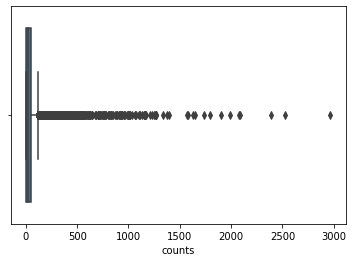

In [17]:
sns.boxplot(x=paths['counts'])

In [31]:
def get_bearing(p1, p2):
    
    '''
    Returns compass bearing from p1 to p2
    
    Parameters
    p1 : namedtuple with lat lon
    p2 : namedtuple with lat lon
    
    Return
    compass bearing of type float
    
    Notes
    Based on https://gist.github.com/jeromer/2005586
    '''
    
    long_diff = np.radians(p2.lon - p1.lon)
    
    lat1 = np.radians(p1.lat)
    lat2 = np.radians(p2.lat)
    
    x = np.sin(long_diff) * np.cos(lat2)
    y = (np.cos(lat1) * np.sin(lat2) 
        - (np.sin(lat1) * np.cos(lat2) 
        * np.cos(long_diff)))
    bearing = np.degrees(np.arctan2(x, y))
    
    # adjusting for compass bearing
    if bearing < 0:
        return bearing + 360
    return bearing

def get_arrows(locations, color='black', size=6, n_arrows=3):
    
    '''
    Get a list of correctly placed and rotated 
    arrows/markers to be plotted
    
    Parameters
    locations : list of lists of lat lons that represent the 
                start and end of the line. 
                eg [[41.1132, -96.1993],[41.3810, -95.8021]]
    arrow_color : default is 'blue'
    size : default is 6
    n_arrows : number of arrows to create.  default is 3
    Return
    list of arrows/markers
    '''
    
    Point = namedtuple('Point', field_names=['lat', 'lon'])
    
    # creating point from our Point named tuple
    p1 = Point(locations[0][0], locations[0][1])
    p2 = Point(locations[1][0], locations[1][1])
    
    # getting the rotation needed for our marker.  
    # Subtracting 90 to account for the marker's orientation
    # of due East(get_bearing returns North)
    rotation = get_bearing(p1, p2) - 90
    
    # get an evenly space list of lats and lons for our arrows
    # note that I'm discarding the first and last for aesthetics
    # as I'm using markers to denote the start and end
    arrow_lats = np.linspace(p1.lat, p2.lat, n_arrows + 2)[1:n_arrows+1]
    arrow_lons = np.linspace(p1.lon, p2.lon, n_arrows + 2)[1:n_arrows+1]
    
    arrows = []
    
    #creating each "arrow" and appending them to our arrows list
    for points in zip(arrow_lats, arrow_lons):
        arrows.append(folium.RegularPolygonMarker(location=points, 
                      fill=True, fill_color=color, color=color, number_of_sides=3, 
                      radius=size, rotation=rotation))
    return arrows


In [33]:
vis = paths.query('counts>1000')

#plot lines between the stations according to number of trips taken
for index, row in vis.iterrows():
    folium.PolyLine([[row.latitude_start,row.longitude_start],[row.latitude_end,row.longitude_end]], color="green", weight=row['counts']/500).add_to(m) 
    arrows = get_arrows(locations=[[row.latitude_start,row.longitude_start],[row.latitude_end,row.longitude_end]], n_arrows=1)
    for arrow in arrows:
        arrow.add_to(m)
    
#put marker for end stations that are not one of the popular start stations    
filt = vis[~vis['end_station_code'].isin(popular['start_station_code'])]
for lat, lng, name in zip(filt.latitude_end,filt.longitude_end,filt.end_station_code):
    m.add_child(folium.CircleMarker(location=[lat,lng], fill=True, radius=2, popup=name, fill_color='blue', color='blue'))
    
m

In [34]:
print("Showing the top %d paths taken" %len(vis))

Showing the top 41 paths taken


In [58]:
#function to plot all of the paths starting from or ending at the chosen station
def plot_paths(station, start):
    '''
    Returns map with paths to/from chosen station plotted as lines
    
    Parameters
    station : int of station code
    start : boolean, (if True plots trips starting from that station, if false plots rides ending at that station)
    
    Return
    folium map
    
    Note:
    uses 'paths' dataframe
    '''
    
    if start==True:
        point = 'start'
        to = 'end'
    else:
        point = 'end'
        to = 'start'

    filt = paths.query('%s_station_code==@station'%point).reset_index(drop=True)

    #create the map and initialize parameters
    montreal = [45.5017, -73.5673]
    smap = folium.Map(location=montreal, tiles='Stamen Terrain', zoom_start=13)
    start_station = filt.loc[1,['latitude_%s'%point,'longitude_%s'%point]]
    
    #add the markers
    smap.add_child(folium.Marker(location=start_station), name=str(station))
    for lat, lng, name in zip(filt['latitude_%s'%to],filt['longitude_%s'%to],filt['%s_station_code'%to]):
        smap.add_child(folium.CircleMarker(location=[lat,lng], fill='true', radius=2, popup=name, fill_color='red', color='red')) #CircleMarker gives dot, Marker gives drop 
    
    #add the lines (all going in same direction so don't need to add arrows (either towards or away from the station of interest))   
    for index, row in filt.iterrows():
        folium.PolyLine([start_station,[row['latitude_%s'%to],row['longitude_%s'%to]]], color="green", weight=row['counts']/100).add_to(smap) 
    return smap

In [60]:
test_map = plot_paths(6012,False)
test_map